# Simplified self-attention (sem pesos treináveis)

**Descrição**  
A *Simplified self-attention* é a forma mais básica do mecanismo de atenção, utilizada para introduzir a ideia central por trás da atenção em modelos de linguagem. Nessa versão simplificada, não há pesos treináveis: o foco está em compreender como cada token de uma sequência pode “olhar” para os demais tokens e combinar suas informações de maneira ponderada.  
Esse mecanismo já é suficiente para ilustrar como dependências entre palavras podem ser capturadas sem recorrer a estruturas recorrentes.

**Objetivo**  
O principal objetivo da *simplified self-attention* é demonstrar, de forma didática, como:
- tokens interagem entre si dentro de uma sequência;
- pesos de atenção são calculados a partir de similaridade entre representações;
- representações contextuais podem ser obtidas como combinações ponderadas dos tokens de entrada.  

Essa camada serve como base conceitual para versões mais avançadas de atenção, como a self-attention com pesos treináveis, atenção causal e multi-head attention.

**Funcionamento**  
De forma resumida, o funcionamento da *simplified self-attention* segue os passos abaixo:

1. Cada token de entrada é representado por um vetor (embedding).
2. Para um token de interesse, calcula-se a similaridade entre o seu vetor e os vetores de todos os tokens da sequência (por exemplo, via produto escalar).
3. Essas similaridades são normalizadas para formar pesos de atenção, geralmente usando uma função como *softmax*.
4. O vetor de saída do token é obtido como uma soma ponderada dos vetores de todos os tokens, usando os pesos de atenção calculados.
5. O processo é repetido para cada token da sequência, resultando em representações contextualizadas.

Mesmo sem parâmetros treináveis, esse mecanismo já evidencia o princípio fundamental da atenção: cada token decide dinamicamente o quanto deve considerar os demais tokens ao construir sua representação.

![O gato sobe no tapete](../../imagens/cap03/01_gato_sobe_no_tapete.png)


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Para reprodutibilidade
torch.manual_seed(42)

## Tokenização simples e vocabulário

In [2]:
# Frase de exemplo
sentence = "O gato sobe no tapete"

# Tokenização simples (já pré-processada)
tokens = sentence.split()

# Construção do vocabulário
vocab = {token: idx for idx, token in enumerate(tokens)}
inv_vocab = {idx: token for token, idx in vocab.items()}

vocab, inv_vocab

({'O': 0, 'gato': 1, 'sobe': 2, 'no': 3, 'tapete': 4},
 {0: 'O', 1: 'gato', 2: 'sobe', 3: 'no', 4: 'tapete'})

## Conversão para token IDs

In [3]:
# Convertendo tokens para IDs
token_ids = torch.tensor([vocab[token] for token in tokens])

token_ids

tensor([0, 1, 2, 3, 4])

## Camada de Embedding

Aqui está o ponto-chave: usamos embeddings mas sem treinamento.

In [4]:
# Dimensão do embedding (pequena para visualização)
embedding_dim = 3

# Camada de embedding
embedding_layer = torch.nn.Embedding(
    num_embeddings=len(vocab),
    embedding_dim=embedding_dim
)

# Obtendo os embeddings
embeddings = embedding_layer(token_ids)

embeddings

tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863],
        [ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094],
        [ 1.1103, -1.6898, -0.9890]], grad_fn=<EmbeddingBackward0>)

## Cálculo da matriz de scores (attention scores)

Aqui aparece claramente o coração da self-attention

* Cada linha → token foco
* Cada coluna → token observado
* Valores maiores → maior similaridade

In [5]:
# Produto escalar entre todos os embeddings
attention_scores = embeddings @ embeddings.T

attention_scores

tensor([[ 0.1849, -0.1108,  0.7695,  0.3487, -0.0757],
        [-0.1108,  1.3486,  1.1390, -0.6898,  2.3374],
        [ 0.7695,  1.1390,  5.4963,  0.6227,  3.0733],
        [ 0.3487, -0.6898,  0.6227,  1.0127, -1.4075],
        [-0.0757,  2.3374,  3.0733, -1.4075,  5.0662]], grad_fn=<MmBackward0>)

## Normalização com softmax (pesos de atenção)

In [6]:
# Softmax linha a linha
attention_weights = F.softmax(attention_scores, dim=1)

attention_weights


tensor([[0.1823, 0.1356, 0.3270, 0.2147, 0.1404],
        [0.0478, 0.2057, 0.1668, 0.0268, 0.5529],
        [0.0079, 0.0115, 0.8945, 0.0068, 0.0793],
        [0.2090, 0.0740, 0.2749, 0.4060, 0.0361],
        [0.0048, 0.0540, 0.1127, 0.0013, 0.8271]], grad_fn=<SoftmaxBackward0>)

## Visualizando os pesos de atenção (legível)

### Inicialmente apenas para o token gato

![Embedding gato](../../imagens/cap03/01_embedding_gato.png)


In [7]:
# Índice do token foco
token_foco = "gato"
idx_foco = vocab[token_foco]

# Scores de similaridade do token "gato" com todos os tokens
scores_gato = attention_scores[idx_foco]

# Pesos de atenção após softmax
weights_gato = attention_weights[idx_foco]

* "gato" → tapete recebe peso alto
* "gato" → sobe recebe atenção moderada
* "gato" → O" recebe atenção baixa

Isso não é semântico ainda, é puramente geométrico (similaridade de embeddings).

In [8]:
print(f"Token foco: '{token_foco}'\n")

for token, weight in zip(tokens, weights_gato):
    print(f"Atenção em '{token:<7}': {weight.item():.2f}")

Token foco: 'gato'

Atenção em 'O      ': 0.05
Atenção em 'gato   ': 0.21
Atenção em 'sobe   ': 0.17
Atenção em 'no     ': 0.03
Atenção em 'tapete ': 0.55


### Entre todos os tokens

In [9]:
for i, token in enumerate(tokens):
    print(f"\nToken foco: '{token}'")
    for j, weight in enumerate(attention_weights[i]):
        print(f"  atenção em '{tokens[j]}': {weight.item():.3f}")


Token foco: 'O'
  atenção em 'O': 0.182
  atenção em 'gato': 0.136
  atenção em 'sobe': 0.327
  atenção em 'no': 0.215
  atenção em 'tapete': 0.140

Token foco: 'gato'
  atenção em 'O': 0.048
  atenção em 'gato': 0.206
  atenção em 'sobe': 0.167
  atenção em 'no': 0.027
  atenção em 'tapete': 0.553

Token foco: 'sobe'
  atenção em 'O': 0.008
  atenção em 'gato': 0.011
  atenção em 'sobe': 0.894
  atenção em 'no': 0.007
  atenção em 'tapete': 0.079

Token foco: 'no'
  atenção em 'O': 0.209
  atenção em 'gato': 0.074
  atenção em 'sobe': 0.275
  atenção em 'no': 0.406
  atenção em 'tapete': 0.036

Token foco: 'tapete'
  atenção em 'O': 0.005
  atenção em 'gato': 0.054
  atenção em 'sobe': 0.113
  atenção em 'no': 0.001
  atenção em 'tapete': 0.827


### Visualização da Self-Attention como Heatmap

Nesta célula, vamos visualizar a matriz de self-attention como um **heatmap**,
onde:

- linhas representam o **token foco**
- colunas representam os **tokens observados**
- valores representam os **pesos de atenção**

Vamos destacar visualmente a linha correspondente ao token **"gato"**.

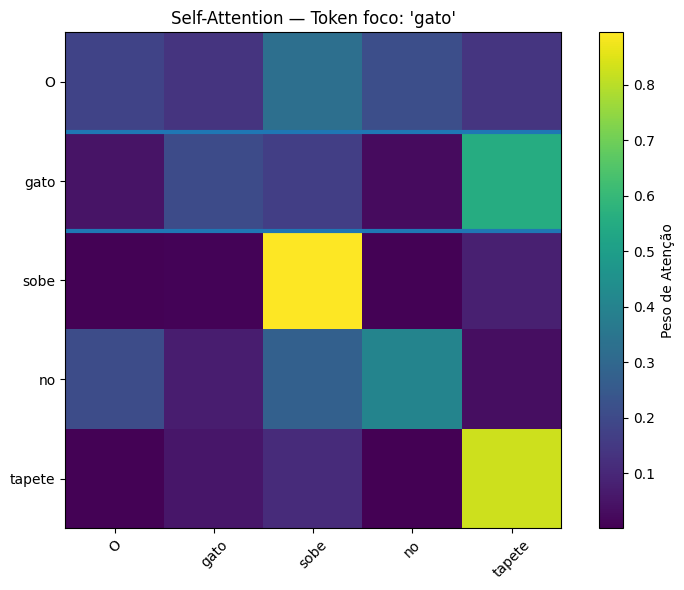

In [10]:
# Converter para numpy para facilitar o plot
attention_matrix = attention_weights.detach().numpy()

token_foco = "gato"
idx_gato = tokens.index(token_foco)

plt.figure(figsize=(8, 6))

plt.imshow(attention_matrix)
plt.colorbar(label="Peso de Atenção")

plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)

# Destaque correto da linha do "gato"
plt.axhline(idx_gato - 0.5, linewidth=3)
plt.axhline(idx_gato + 0.5, linewidth=3)

plt.title("Self-Attention — Token foco: 'gato'")

plt.tight_layout()
plt.show()

## Embeddings contextualizados (saída da atenção)

### O context vector é o embedding do token + informação relevante dos outros tokens.

Ou seja:

* O token olha para os outros tokens
* Decide quem é relevante
* Combina essas informações
* Produz um vetor novo → context vector

Agora o **gato** já sabe que tem que prestar mais atenção no **tapete**

In [11]:
# Combinação ponderada dos embeddings
contextual_embeddings = attention_weights @ embeddings

contextual_embeddings

tensor([[ 1.0281, -0.4599,  0.2033],
        [ 1.0529, -1.2512, -0.4753],
        [ 2.0704, -0.7129,  0.3398],
        [ 0.8431, -0.0754,  0.4550],
        [ 1.1817, -1.5290, -0.7739]], grad_fn=<MmBackward0>)

### Embedding contextualizado apenas para o token 'Gato'

In [12]:
# Embedding original do token "gato"
embedding_original_gato = embeddings[idx_foco]

# Embedding contextualizado via self-attention
embedding_contextual_gato = weights_gato @ embeddings

print("Token:", token_foco)
print("\nEmbedding original:")
print(embedding_original_gato.detach().numpy())

print("\nEmbedding contextualizado:")
print(embedding_contextual_gato.detach().numpy())

Token: gato

Embedding original:
[ 0.23033303 -1.1228564  -0.18632829]

Embedding contextualizado:
[ 1.0528603 -1.2512183 -0.4752503]


### Embedding contextualizado entre todos os tokens

In [13]:
for i, token in enumerate(tokens):
    print(f"\nPalavra: '{token}'")
    print("Embedding original:      ", embeddings[i].detach().numpy())
    print("Embedding contextualizado:", contextual_embeddings[i].detach().numpy())


Palavra: 'O'
Embedding original:       [0.33669037 0.1288094  0.23446237]
Embedding contextualizado: [ 1.0280503  -0.4599012   0.20330468]

Palavra: 'gato'
Embedding original:       [ 0.23033303 -1.1228564  -0.18632829]
Embedding contextualizado: [ 1.0528603 -1.2512183 -0.4752503]

Palavra: 'sobe'
Embedding original:       [ 2.2082014  -0.63799703  0.46165723]
Embedding contextualizado: [ 2.0703762  -0.7128629   0.33978036]

Palavra: 'no'
Embedding original:       [0.26735088 0.53490466 0.8093572 ]
Embedding contextualizado: [ 0.8430897  -0.07536834  0.45503342]

Palavra: 'tapete'
Embedding original:       [ 1.1102903 -1.689799  -0.9889599]
Embedding contextualizado: [ 1.1817192  -1.5289683  -0.77386177]


In [14]:
def pca_2d(x: torch.Tensor) -> torch.Tensor:
    """
    Aplica PCA para reduzir para 2 dimensões usando SVD.

    Parâmetros:
    ----------
    x : torch.Tensor (n_samples, n_features)

    Retorno:
    -------
    torch.Tensor (n_samples, 2)
    """
    # Centraliza os dados
    x_centered = x - x.mean(dim=0, keepdim=True)

    # SVD
    U, S, Vt = torch.linalg.svd(x_centered, full_matrices=False)

    # Projeção nas 2 primeiras componentes
    return x_centered @ Vt[:2].T


In [15]:
emb_pca = pca_2d(embeddings)
ctx_pca = pca_2d(contextual_embeddings)

emb_np = emb_pca.detach().cpu().numpy()
ctx_np = ctx_pca.detach().cpu().numpy()

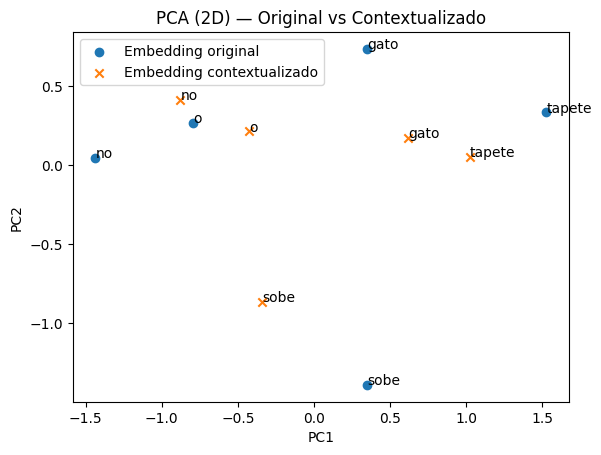

In [21]:
tokens = ["o", "gato", "sobe", "no", "tapete"]

plt.figure()

plt.scatter(emb_np[:, 0], emb_np[:, 1], marker='o', label='Embedding original')
plt.scatter(ctx_np[:, 0], ctx_np[:, 1], marker='x', label='Embedding contextualizado')

for i, token in enumerate(tokens):
    # embedding original
    plt.text(
        emb_np[i, 0],
        emb_np[i, 1],
        token,
        fontsize=10,
        ha='left'
    )

    # embedding contextualizado
    plt.text(
        ctx_np[i, 0],
        ctx_np[i, 1],
        token,
        fontsize=10,
        ha='left'
    )

plt.legend(loc="best")
plt.title('PCA (2D) — Original vs Contextualizado')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
